# Step 5: Using sklearn's decision tree regressor and random forest regressor for comparison with my algorithms made from scratch

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from helper_functions import (
    calculate_mse, calculate_rmse, calculate_mae, calculate_r2, regression_metrics,
    plot_distribution,
    plot_actual_vs_predicted,
    plot_summary_statistics,
    plot_histogram
)

In [2]:
current_dir = os.getcwd()
dir_contents = os.listdir(current_dir)

for filename in dir_contents:
    file_path = os.path.join(current_dir, filename)
    if os.path.isfile(file_path):
        print(filename)

creating_dataframe.ipynb
data_analysis.ipynb
data_preprocessing.ipynb
dt_and_rf_from_scratch.ipynb
helper_functions.py
sklearn_dt_and_rf.ipynb


In [3]:
df = pd.read_csv('../dataset/failed_hdds_with_rul.csv')

In [4]:
df.shape

(18588, 31)

In [5]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,date_diff_days
0,4000787030016,0,119.0,208663312.0,92.0,0.0,100.0,9.0,100.0,0.0,...,7273.0,23.0,23.0,100.0,0.0,100.0,0.0,200.0,0.0,26
1,12000138625024,0,79.0,155920208.0,98.0,0.0,100.0,2.0,100.0,24.0,...,633.0,40.0,40.0,100.0,88.0,100.0,88.0,200.0,0.0,26
2,8001563222016,0,77.0,54823024.0,98.0,0.0,100.0,2.0,100.0,0.0,...,14936.0,29.0,29.0,100.0,0.0,100.0,0.0,200.0,0.0,52
3,12000138625024,0,84.0,235330528.0,94.0,0.0,100.0,5.0,100.0,0.0,...,1501.0,25.0,25.0,100.0,0.0,100.0,0.0,200.0,0.0,83
4,8001563222016,0,67.0,240427784.0,95.0,0.0,100.0,4.0,100.0,3896.0,...,14353.0,38.0,38.0,100.0,0.0,100.0,0.0,200.0,0.0,27


### Checking the lowest and highest values for RUL

In [6]:
min_value = df['date_diff_days'].min()
max_value = df['date_diff_days'].max()
print(f'Target values should range from {min_value} to {max_value} days')

Target values should range from 0 to 88 days


In [7]:
RUL = df['date_diff_days'].values
RUL

array([26, 26, 52, ...,  0,  0,  0], dtype=int64)

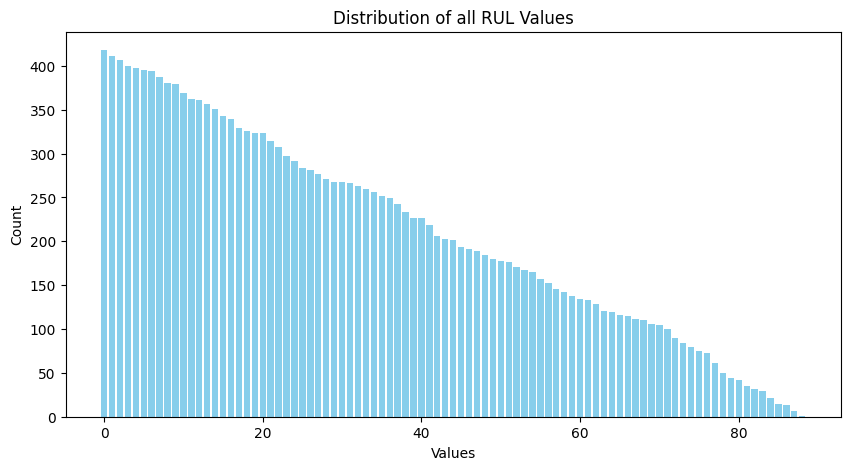

In [8]:
plot_distribution(RUL, title='Distribution of all RUL Values', xlabel='Values', ylabel='Count', save_path='../img/rul_distribution.png')

### Splitting data

In [4]:
X = df.drop(['date_diff_days'], axis=1).values

In [5]:
y = df['date_diff_days'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Decision Tree

### Sklearn's decision tree regressor

Model: simple tree

CPU times: total: 78.1 ms
Wall time: 94.3 ms


{'MSE': 416.56716108923246,
 'RMSE': 20.409976998743346,
 'MAE': 16.975422685654866,
 'R2 score': 0.06248898603904607}

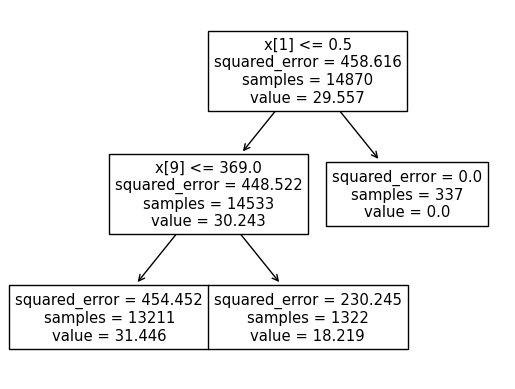

In [12]:
%%time

dtr = DecisionTreeRegressor(max_depth=2, min_samples_split=2)
dtr.fit(X_train, y_train)
plot_tree(dtr)
y_pred = dtr.predict(X_test)

regression_metrics(y_test, y_pred, model_name='simple tree')

### Applying hyperparamater tuning to find the most optimal parameter values

In [15]:
%%time

hyperparameter_values = {'max_depth': [], 'min_samples_split': [], 'mse': [], 'rmse': [], 'mae': [], 'r2': []}

for max_depth in range(2, 41, 2):
    for min_samples_split in range(2, 5, 2):
        tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        
        mse = calculate_mse(y_test, y_pred)
        rmse = calculate_rmse(y_test, y_pred)
        mae = calculate_mae(y_test, y_pred)
        r2 = calculate_r2(y_test, y_pred)
        
        hyperparameter_values['max_depth'].append(max_depth)
        hyperparameter_values['min_samples_split'].append(min_samples_split)
        hyperparameter_values['mse'].append(mse)
        hyperparameter_values['rmse'].append(rmse)
        hyperparameter_values['mae'].append(mae)
        hyperparameter_values['r2'].append(r2)
        
hyperparameter_df = pd.DataFrame(hyperparameter_values)
hyperparameter_df.sort_values('rmse').head()

CPU times: total: 3.83 s
Wall time: 4.66 s


,max_depth,min_samples_split,mse,rmse,mae,r2
22,24,2,21.713609,4.659786,1.996433,0.951132
26,28,2,21.933827,4.683356,1.971965,0.950637
38,40,2,22.170925,4.708601,2.005917,0.950103
36,38,2,22.170925,4.708601,2.005917,0.950103
34,36,2,22.170925,4.708601,2.005917,0.950103


In [16]:
hyperparameter_df.sort_values('r2', ascending=False).head()

,max_depth,min_samples_split,mse,rmse,mae,r2
22,24,2,21.713609,4.659786,1.996433,0.951132
26,28,2,21.933827,4.683356,1.971965,0.950637
38,40,2,22.170925,4.708601,2.005917,0.950103
36,38,2,22.170925,4.708601,2.005917,0.950103
34,36,2,22.170925,4.708601,2.005917,0.950103


### Using RandomizedSearchCV for hyperparameter tuning

In [17]:
%%time

param_dist = {
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

tree = DecisionTreeRegressor(random_state=0)
random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Randomised Tuned Tree')

Best Hyperparameters: {'min_samples_split': 2, 'max_depth': 52}
Model: Randomised Tuned Tree

CPU times: total: 484 ms
Wall time: 9.76 s


{'MSE': 22.170925228617538,
 'RMSE': 4.708601196599425,
 'MAE': 2.0059171597633134,
 'R2 score': 0.9501029160887666}

### Getting the top 5 scores from the RandomizedSearchCV

In [18]:
rank_test_score = random_search.cv_results_['rank_test_score']

In [19]:
# Get the indices of the top 5 rankings (top 5 smallest values)
top_results_indices = np.argsort(rank_test_score)[:5]

In [20]:
top_results_indices

array([22, 12, 11, 33, 43], dtype=int64)

In [21]:
print("Top 5 Hyperparameter Sets:")
for i, index in enumerate(top_results_indices, 1):
    params = {key[5:]: random_search.cv_results_[key][index] for key in random_search.cv_results_.keys() if key.startswith('param_')}
    score = random_search.cv_results_['mean_test_score'][index]
    print(f"Rank {i}: Hyperparameters: {params}, R2 Score: {score:.4f}")

Top 5 Hyperparameter Sets:
Rank 1: Hyperparameters: {'_min_samples_split': 2, '_max_depth': 50}, R2 Score: 0.9242
Rank 2: Hyperparameters: {'_min_samples_split': 2, '_max_depth': 80}, R2 Score: 0.9242
Rank 3: Hyperparameters: {'_min_samples_split': 2, '_max_depth': 52}, R2 Score: 0.9242
Rank 4: Hyperparameters: {'_min_samples_split': 4, '_max_depth': 40}, R2 Score: 0.9234
Rank 5: Hyperparameters: {'_min_samples_split': 4, '_max_depth': 46}, R2 Score: 0.9234


### Re-training and testing with the best hyperparameters

In [7]:
%%time

dtr = DecisionTreeRegressor(max_depth=24, min_samples_split=2, random_state=0)
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

regression_metrics(y_test, y_pred_dtr, model_name='Best Decision Tree')

Model: Best Decision Tree

CPU times: total: 109 ms
Wall time: 147 ms


{'MSE': 21.713608792108754,
 'RMSE': 4.659786346186781,
 'MAE': 1.996433129881893,
 'R2 score': 0.9511321359508683}

### Plotting actual vs predicted values

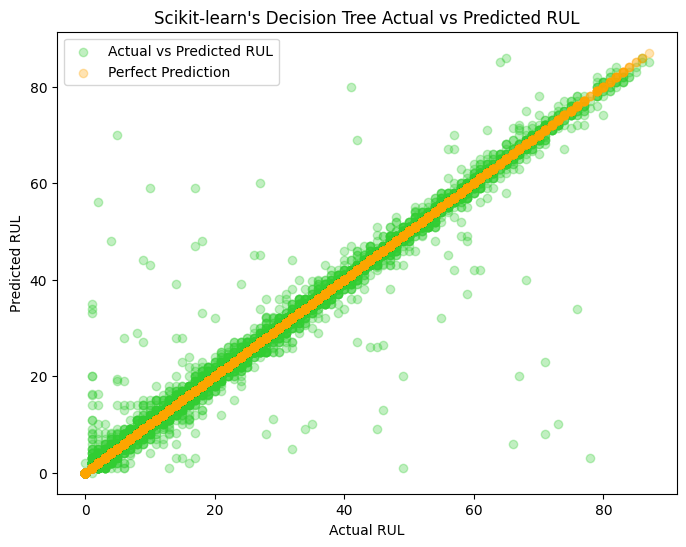

In [8]:
plot_actual_vs_predicted(y_test, 
                         y_pred_dtr, 
                         title="Scikit-learn's Decision Tree Actual vs Predicted RUL", 
                         save_path='../img/decision_tree_sklearn.png')

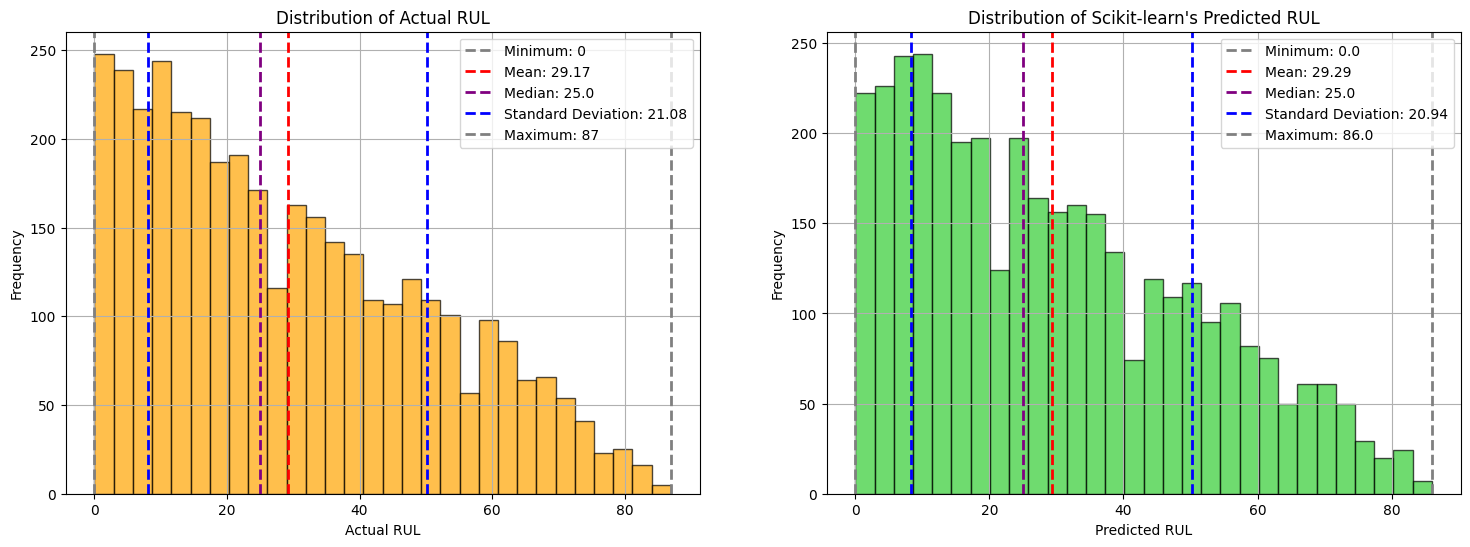

In [9]:
plot_summary_statistics(y_true=y_test,
                        y_pred=y_pred_dtr,
                        titles=("Distribution of Actual RUL", "Distribution of Scikit-learn's Predicted RUL"),
                        save_path='../img/summary_statistics_decision_tree_sklearn.png')

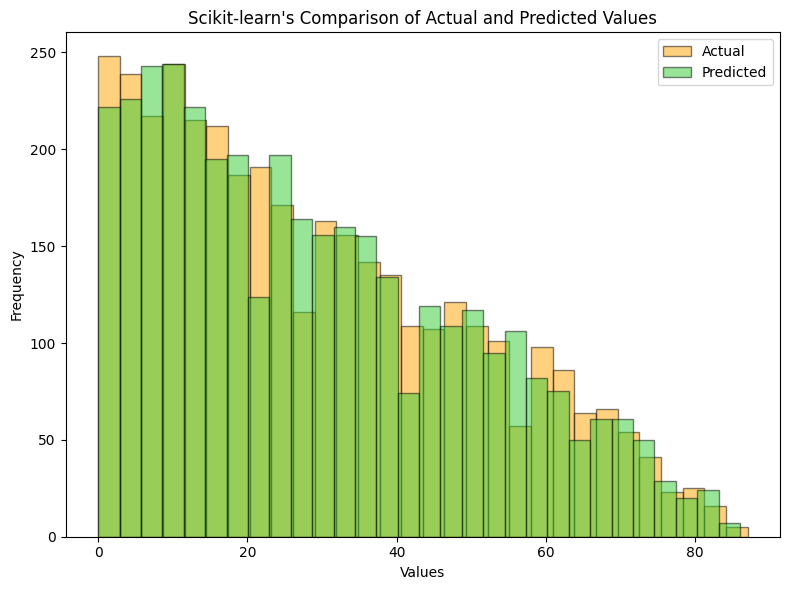

In [10]:
plot_histogram(y_true=y_test, 
               y_pred=y_pred_dtr, 
               title="Scikit-learn's Comparison of Actual and Predicted Values",
               save_path='../img/histogram_decision_tree_sklearn.png')

# Random Forest

### Using RandomizedSearchCV for hyperparameter tuning WITH feature selection

In [48]:
%%time

param_dist = {
    'n_estimators': np.arange(2, 101, 2),
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

forest = RandomForestRegressor(max_features='sqrt', random_state=0)
random_search = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Hyperparameter Tuned Forest')

Best Hyperparameters: {'n_estimators': 88, 'min_samples_split': 2, 'max_depth': 70}
Model: Hyperparameter Tuned Forest

CPU times: total: 2.97 s
Wall time: 58.5 s


{'MSE': 16.13666787632542,
 'RMSE': 4.017047158837623,
 'MAE': 2.4666076226609444,
 'R2 score': 0.9636833978388316}

### Using RandomizedSearchCV for hyperparameter tuning WITHOUT feature selection

In [31]:
%%time

param_dist = {
    'n_estimators': np.arange(2, 101, 2),
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

forest = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Hyperparameter Tuned Forest')

Best Hyperparameters: {'n_estimators': 88, 'min_samples_split': 2, 'max_depth': 70}
Model: Hyperparameter Tuned Forest

CPU times: total: 9.09 s
Wall time: 4min 40s


{'MSE': 9.254783499089097,
 'RMSE': 3.042167565912354,
 'MAE': 1.6106094129258466,
 'R2 score': 0.9791715183704518}

### Re-training and testing with the best hyperparameters

In [15]:
%%time

rfr = RandomForestRegressor(n_estimators=88, max_depth=70, min_samples_split=2, max_features='sqrt', random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Best Random Forest with feature selection')

Model: Best Random Forest with feature selection

CPU times: total: 2.25 s
Wall time: 2.42 s


{'MSE': 16.13666787632542,
 'RMSE': 4.017047158837623,
 'MAE': 2.4666076226609444,
 'R2 score': 0.9636833978388316}

In [11]:
%%time

rfr = RandomForestRegressor(n_estimators=88, max_depth=70, min_samples_split=2, random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Best Random Forest')

Model: Best Random Forest

CPU times: total: 8.59 s
Wall time: 8.93 s


{'MSE': 9.254783499089097,
 'RMSE': 3.042167565912354,
 'MAE': 1.6106094129258466,
 'R2 score': 0.9791715183704518}

### Plotting actual vs predicted values

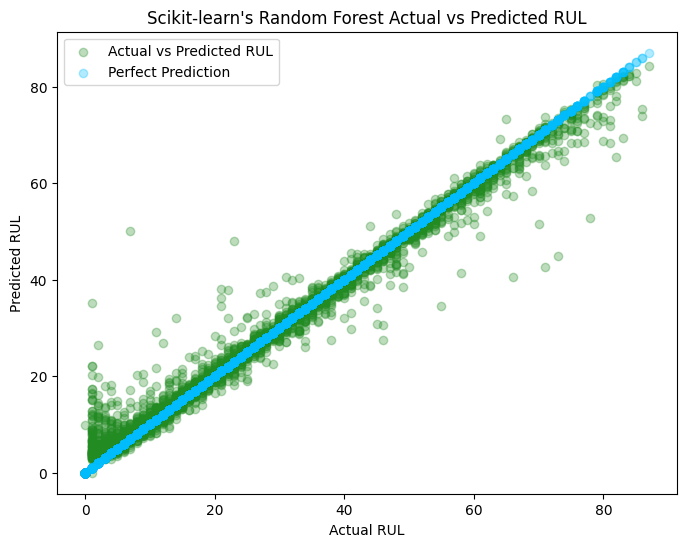

In [12]:
plot_actual_vs_predicted(y_test, 
                         y_pred_rfr, 
                         title="Scikit-learn's Random Forest Actual vs Predicted RUL", 
                         true_color='deepskyblue', 
                         predicted_color='forestgreen',
                         save_path='../img/random_forest_sklearn.png')

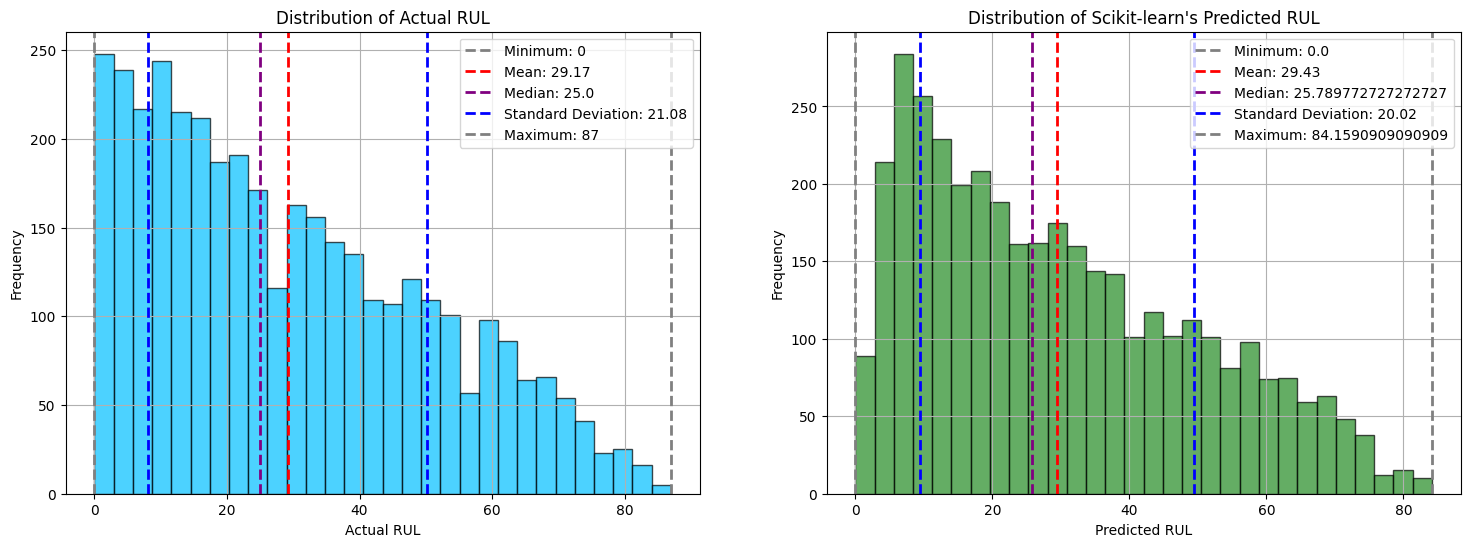

In [13]:
plot_summary_statistics(y_test, y_pred_rfr,
                        titles=("Distribution of Actual RUL", "Distribution of Scikit-learn's Predicted RUL"),
                        colors=('deepskyblue', 'forestgreen'),
                        save_path='../img/summary_statistics_random_forest_sklearn.png')

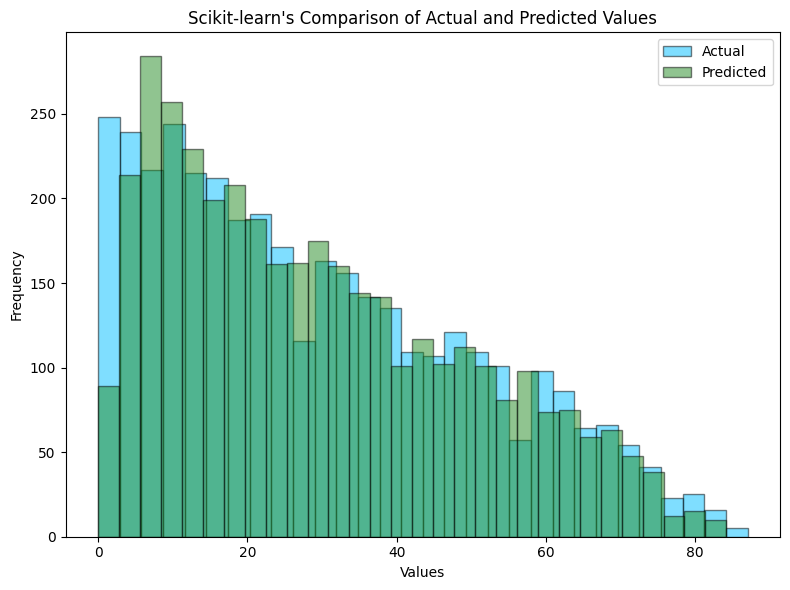

In [14]:
plot_histogram(y_true=y_test, 
               y_pred=y_pred_rfr, 
               title="Scikit-learn's Comparison of Actual and Predicted Values",
               actual_color='deepskyblue', 
               predicted_color='forestgreen',
               save_path='../img/histogram_random_forest_sklearn.png')